*Space Titantic*
***

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

![](https://storage.googleapis.com/kaggle-media/competitions/Spaceship%20Titanic/joel-filipe-QwoNAhbmLLo-unsplash.jpg)

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!
To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

**[Submit Prediction](https://www.kaggle.com/competitions/spaceship-titanic/submit)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
#Regressions modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
%matplotlib inline

In [2]:
data = pd.read_csv('train.csv')
Test = pd.read_csv('test.csv')
data.describe()
test = Test.copy()
data['Test'] = 0
test['Test'] = 1
all_data = pd.concat([data, test])

remove_cols = ['RoomService', 'FoodCourt', 'ShoppingMall','Spa','VRDeck']
list = []
for col in remove_cols:
    all_data[col] = all_data[col].fillna(0)

all_data["Total"] = all_data['RoomService'] + all_data['FoodCourt']+ all_data['ShoppingMall']+ all_data['Spa']+ all_data['VRDeck']
all_data['Costs'] = np.log(all_data.Total +1)

all_data["VIP"] = all_data.VIP.fillna(False)
all_data["CryoSleep"] = all_data.CryoSleep.fillna(False)
all_data["Age"] = all_data.Age.fillna(all_data.Age.median())
all_data["Destination"] = all_data.Destination.fillna('TRAPPIST-1e')
all_data["HomePlanet"] = all_data.HomePlanet.fillna('Earth')


In [3]:
nub = ['Age', 'Group_Count','Costs']
cat = ['HomePlanet','Destination', 'CabinDeck', 'CabinPort']

all_data['groups'] = [str(x)[:4] for x in all_data['PassengerId']]
dic = dict(all_data.groups.value_counts())
all_data["Group_Count"] = [dic[x] for x in all_data['groups']]

all_data['CabinPort'] = all_data.Cabin.apply(lambda x: 'N' if pd.isna(x) else str(x)[-1])
all_data['CabinDeck'] = all_data.Cabin.apply(lambda x: 'N' if pd.isna(x) else str(x)[0])
all_data['CryoSleep'] = all_data.CryoSleep.map({True: 1, False:0})
all_data['VIP'] = all_data.VIP.map({True: 1, False:0})
all_data['Transported'] = all_data.Transported.map({True: 1, False:0})

all_data.drop(columns= remove_cols, inplace=True)
all_data.drop(columns= ["Name", "groups", 'Total', 'Cabin', 'PassengerId'], inplace=True)



X = all_data[all_data.Test == 0]
y = X['Transported']
X.drop(columns=['Transported'], inplace=True)
X = pd.get_dummies(X, columns=cat)

test = all_data[all_data.Test == 1]
test.drop(columns='Transported', inplace=True)
test = pd.get_dummies(test, columns=cat)

c:\Users\j4cks\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
all_data.groupby(["Destination", 'HomePlanet'])['Age'].count()

Destination    HomePlanet
55 Cancri e    Earth         1037
               Europa        1310
               Mars           294
PSO J318.5-22  Earth         1088
               Europa          29
               Mars            67
TRAPPIST-1e    Earth         5028
               Europa        1794
               Mars          2323
Name: Age, dtype: int64

So if Destination is 55 Cancri then most likely Europa
PSO J318.5-22 => Earth
TRAPPIST-1e => Earth

HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
Transported    4277
Test              0
Costs             0
Group_Count       0
CabinPort         0
CabinDeck         0
dtype: int64


<AxesSubplot:>

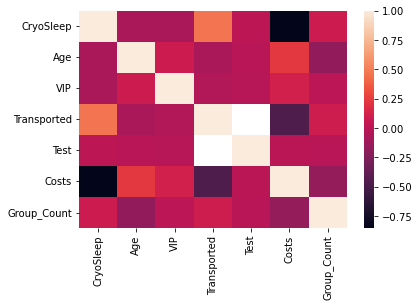

In [5]:
print(all_data.isnull().sum())
#HomePlanet could group by departed 
#CryoSleep 
sns.heatmap(all_data.corr())

EDA:
Looking at the data

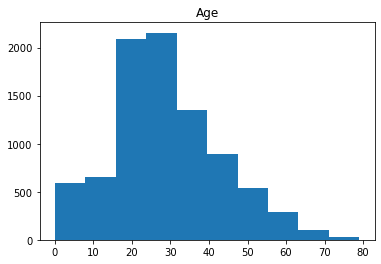

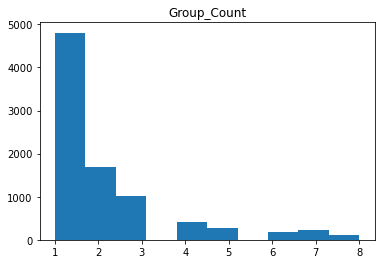

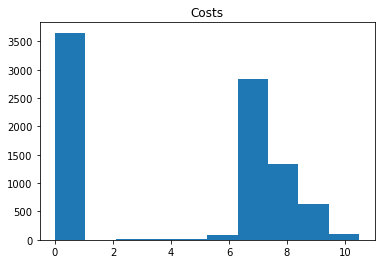

In [6]:
#Numerical
for number in nub:
    plt.hist(X[number])
    plt.title(number)
    plt.show()

In [7]:
all_data

,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Test,Costs,Group_Count,CabinPort,CabinDeck
0,Europa,0,TRAPPIST-1e,39.0,0,0.0,0,0.000000,1,P,B
1,Earth,0,TRAPPIST-1e,24.0,0,1.0,0,6.602588,1,S,F
2,Europa,0,TRAPPIST-1e,58.0,1,0.0,0,9.248021,2,S,A
3,Europa,0,TRAPPIST-1e,33.0,0,0.0,0,8.551981,2,S,A
4,Earth,0,TRAPPIST-1e,16.0,0,1.0,0,6.995766,1,S,F
...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,1,TRAPPIST-1e,34.0,0,NaN,1,0.000000,2,S,G
4273,Earth,0,TRAPPIST-1e,42.0,0,NaN,1,6.926577,1,N,N
4274,Mars,1,55 Cancri e,27.0,0,NaN,1,0.000000,1,P,D
4275,Europa,0,TRAPPIST-1e,27.0,0,NaN,1,8.072155,1,P,D


Filling NA data points
For the Services can just median value of all the columns so that you dont fill each of them 
Passenger Id gggg-pp, gggg indicates group and pp indicates size of group 
find the amount per group
Cabin So that it has Port or Starboard or Null
Figure out what to do with the spending adding all up, and logging it or trying to create categories
Names seeing if they are together


In [8]:
pd.pivot_table(all_data, index='Transported', values=nub)

,Age,Costs,Group_Count
Transported,,,
0.0,29.862572,5.995575,1.902665
1.0,27.733440,2.535511,2.166514


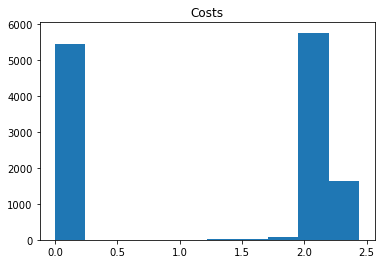

In [9]:
plt.hist(np.log(all_data['Costs'] +1))
plt.title('Costs')
plt.show()

In [10]:
X.describe(include='all')

,CryoSleep,Age,VIP,Test,Costs,Group_Count,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,...,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_N,CabinDeck_T,CabinPort_N,CabinPort_P,CabinPort_S
count,8693.000000,8693.000000,8693.000000,8693.0,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,...,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.349362,28.790291,0.022892,0.0,4.253005,2.035546,0.552514,0.245140,0.202347,0.207063,...,0.085931,0.054987,0.100771,0.321408,0.294375,0.022892,0.000575,0.022892,0.483838,0.493270
std,0.476796,14.341404,0.149568,0.0,3.689350,1.596347,0.497263,0.430195,0.401772,0.405224,...,0.280279,0.227968,0.301042,0.467044,0.455787,0.149568,0.023977,0.149568,0.499767,0.499983
min,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.0,6.575076,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,37.000000,0.000000,0.0,7.273786,3.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,79.000000,1.000000,0.0,10.490941,8.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
X_train, X_val, y_train, y_val = train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=0)

In [12]:
#Used to calculate the overall accurancy of each of the modeling
def get_score(df):
    df.fit(X_train, y_train)
    cv = cross_val_score(df,X,y, cv=5)
    return print(cv.mean())

#Fitting it to the results
def fit(df):
    df.fit(X,y)
    preds = df.predict(test)
    list = [True if x == 1 else False for x in preds]
    return list

In [13]:
X.describe(include='all')
y_val.shape

(1739,)

Different models
- Naive Bayes
- Logistic Regression
- Decision Tree 
- K Nearest Neighbor
- Random Forrest
- Xtreme Gradient Boosting

In [14]:
rf = RandomForestClassifier(n_estimators=150, random_state=0, max_depth=10)
get_score(rf)

0.748420550413548


In [15]:
xgb = XGBClassifier(n_estimators=200, eval_metric='rmse', use_label_encoder=False, learning_rate=0.02, random_state=0)
get_score(xgb)

0.7483048800581794


In [16]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=2000)
get_score(lr)

0.7400232002440459


In [17]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
get_score(gnb)

0.6832035791637192


In [18]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(random_state=0)
get_score(dt)

0.6688134722877518


In [19]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
get_score(knn)

0.6910162911240206


In [20]:
from sklearn.svm import SVC
svc = SVC(probability=True)
get_score(svc)

0.7366880824462295


In [21]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('lr',lr),('knn',knn),('rf',rf),('gnb',gnb),('svc',svc),('xgb',xgb)], voting = 'soft') 
get_score(voting_clf)

0.7385284189754968


In [22]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [24]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [25]:
lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X, y)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Logistic Regression
Best Score: 0.7420938187164958
Best Parameters: {'C': 0.23357214690901212, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}


In [26]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X,y)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.7117249904214623
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}


In [27]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'n_estimators': [400,450,500,550],
               'criterion':['gini','entropy'],
                                  'bootstrap': [True],
                                  'max_depth': [15, 20, 25],
                                  'max_features': ['auto','sqrt', 10],
                                  'min_samples_leaf': [2,3],
                                  'min_samples_split': [2,3]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X,y)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Random Forest
Best Score: 0.7458896327466218
Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 500}


In [ ]:
best_rf = best_clf_rf.best_estimator_.fit(X, y)
feat_importances = pd.Series(best_rf.feature_importances_, index=X_scaled.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
xgb = XGBClassifier(random_state = 1)

param_grid = {
    'n_estimators': [450,500,550],
    'colsample_bytree': [0.75,0.8,0.85],
    'max_depth': [None],
    'reg_alpha': [1],
    'reg_lambda': [2, 5, 10],
    'subsample': [0.55, 0.6, .65],
    'learning_rate':[0.5],
    'gamma':[.5,1,2],
    'min_child_weight':[0.01],
    'sampling_method': ['uniform']
}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X,y)
clf_performance(best_clf_xgb,'XGB')

In [ ]:
preds = fit(rf)

output = pd.DataFrame({'PassengerId': Test.PassengerId,'Transported': preds})

output.to_csv('submission.csv', index=False)